In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [18]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using device : {device}")

Using device : cuda


In [8]:
import kagglehub
path = kagglehub.dataset_download("zalando-research/fashionmnist")
df = pd.read_csv(path + '/fashion-mnist_train.csv')

Using Colab cache for faster access to the 'fashionmnist' dataset.


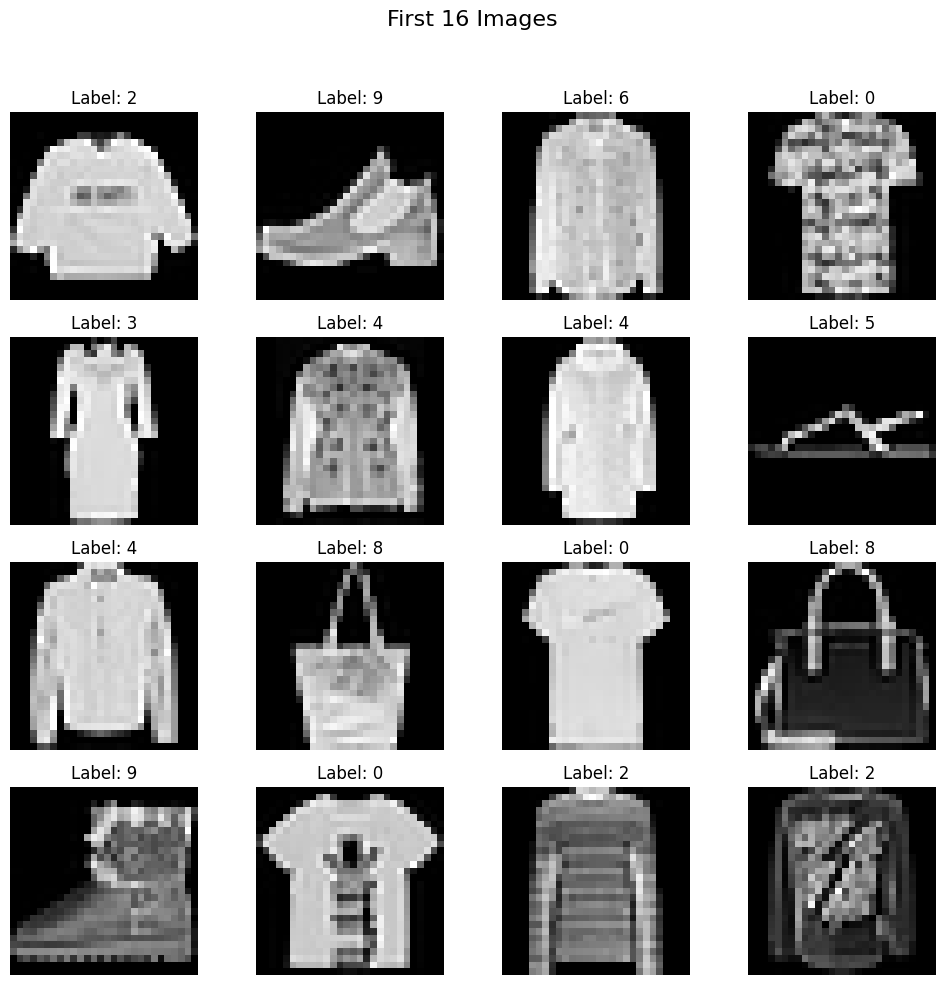

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plotting the images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # top reserved for title
plt.show()

In [5]:
df = pd.read_csv(path + "/data.csv")
df.drop(columns=["Unnamed: 32", "id"], inplace=True)

In [10]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train = X_train/255.0
X_test = X_test/255.0

In [13]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)   #2D Image - Batch SIze, channel , height , width
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [14]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

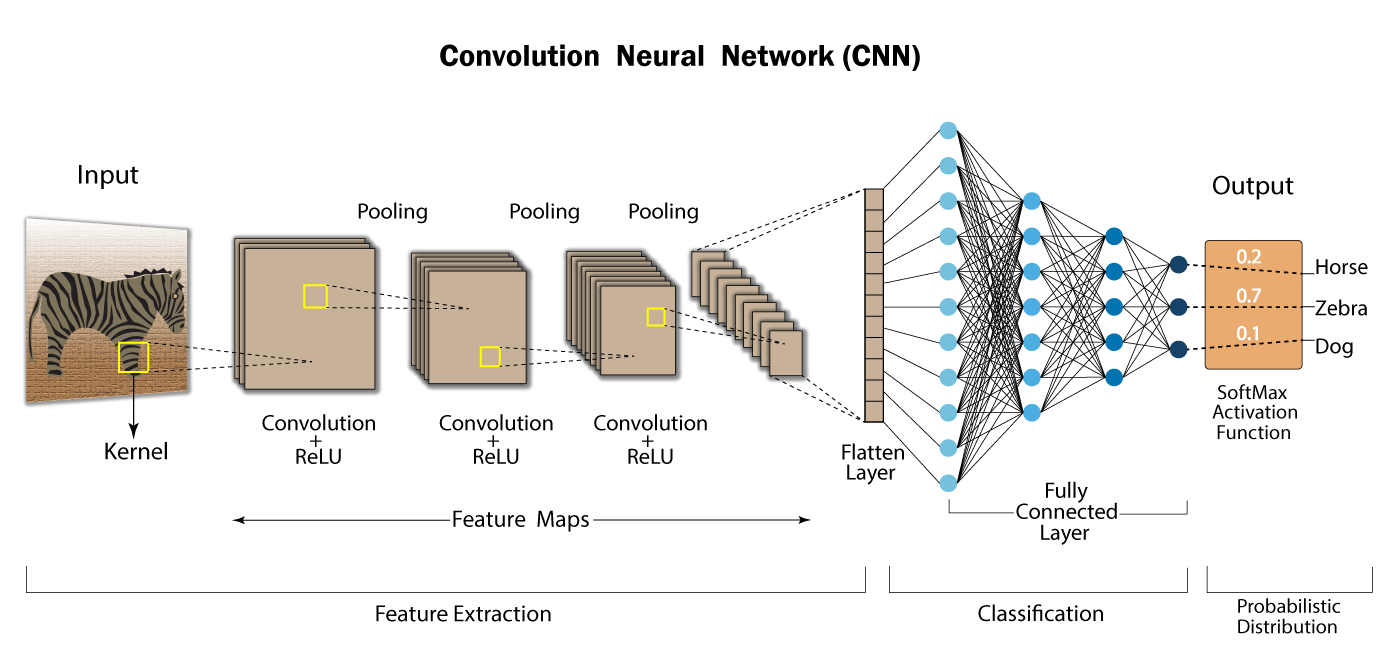

In [24]:
class MyNN(nn.Module):
    def __init__(self, input_features):
      super().__init__()

      self.features =  nn.Sequential(
          nn.Conv2d(in_channels=input_features, out_channels=32, kernel_size=3, padding='same'),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(64*7*7, 128),
          nn.ReLU(),
          nn.Dropout(0.2),

          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Dropout(0.2),

          nn.Linear(64, 10)
      )


    def forward(self, x):
      x = self.features(x)
      x = self.classifier(x)
      return x

In [25]:
learning_rate = 0.01
epochs = 100

In [26]:
model = MyNN(1)
model.to(device=device)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [28]:
# training loop
for epoch in range(epochs):

    total_epochs_loss = 0

    for batch_features, batch_labels in train_loader:

        # move data to gpu
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epochs_loss += loss.item()

    avg_loss = total_epochs_loss / len(train_loader)
    print(f"Epoch: {epoch + 1}, Loss: {avg_loss}")

Epoch: 1, Loss: 0.5358005909472704
Epoch: 2, Loss: 0.3127090190549692
Epoch: 3, Loss: 0.2668662582139174
Epoch: 4, Loss: 0.23694423601900538
Epoch: 5, Loss: 0.2123499020213882
Epoch: 6, Loss: 0.19372114049146572
Epoch: 7, Loss: 0.17605434387053054
Epoch: 8, Loss: 0.1616914847996086
Epoch: 9, Loss: 0.14912305917590857
Epoch: 10, Loss: 0.13554118008818478
Epoch: 11, Loss: 0.12404817783397933
Epoch: 12, Loss: 0.1155478355102241
Epoch: 13, Loss: 0.10361865703963365
Epoch: 14, Loss: 0.09515058365960916
Epoch: 15, Loss: 0.0894291398593535
Epoch: 16, Loss: 0.07891068555243934
Epoch: 17, Loss: 0.0746805078072939
Epoch: 18, Loss: 0.06970148720270178
Epoch: 19, Loss: 0.0626555159065174
Epoch: 20, Loss: 0.05687574678087064
Epoch: 21, Loss: 0.05229352422469916
Epoch: 22, Loss: 0.04798586135233442
Epoch: 23, Loss: 0.04557040628164153
Epoch: 24, Loss: 0.04106369436068538
Epoch: 25, Loss: 0.03588341717918714
Epoch: 26, Loss: 0.036247016436701716
Epoch: 27, Loss: 0.03194158649235033
Epoch: 28, Loss: 0

In [29]:
total = 0
correct = 0

with torch.no_grad():

    for batch_features, batch_labels in test_loader:

        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        _, predicted = torch.max(model(batch_features), 1)
        total = total + batch_labels.size(0)
        correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9206666666666666


In [30]:
total = 0
correct = 0

with torch.no_grad():

    for batch_features, batch_labels in train_loader:

        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        _, predicted = torch.max(model(batch_features), 1)
        total = total + batch_labels.size(0)
        correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9990208333333334
